Jelle, July 2016. Updated November 2016

This notebooks is a WIMP analysis example using only one WIMP mass and an easy-to-compute rate uncertainty.

In [1]:
from copy import deepcopy

import numpy as np
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc('font', size=16)
plt.rcParams['figure.figsize'] = (12.0, 10.0)    # resize plots

from scipy import stats

from laidbax.base_model import config
import blueice as bi

# Create likelihoods

This creates two likelihood functions: a basic one, and one with a rather ridiculous 300% rate uncertainty on the neutron background. At least you'll see some effect of the profiling!

In [2]:
lf = bi.UnbinnedLogLikelihood(config)
lf.add_rate_parameter('wimp_50gev')
lf.prepare()

plf = bi.UnbinnedLogLikelihood(config)
plf.add_rate_parameter('wimp_50gev')
plf.add_rate_uncertainty('radiogenics', 3)
plf.prepare()

The rate parameter to the likelihood function is a multiplier for the _total_ rate of WIMPs, (not just the rate of detectable events). This was done so we can easily convert to a cross section: just multiply by the reference cross section (1e-45 cm2) for which the WIMP spectrum was generated.

# Example datasets

The code below creates four example datasets with increasing amounts of wimps. We plot the events in (cS1, cS2) space and the (profile) likelihood ratio of different WIMP rate hypotheses (with the best fit in the denominator). 

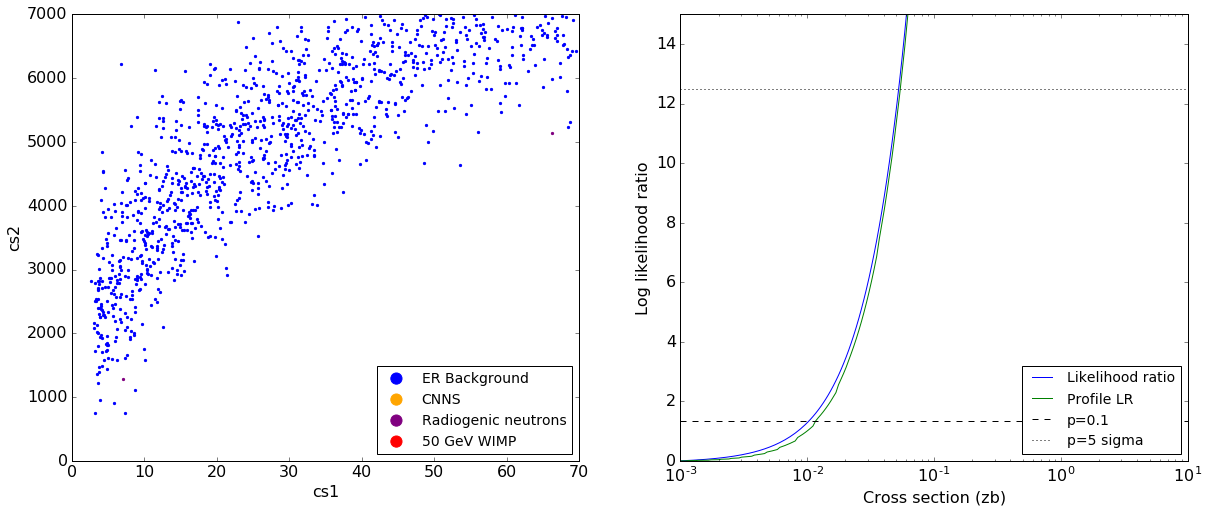

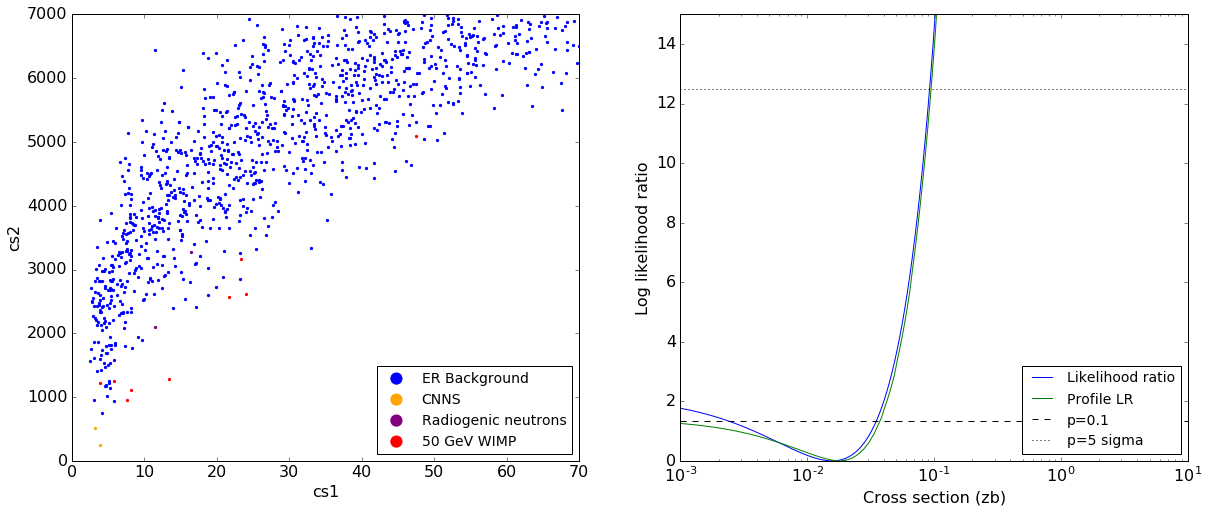

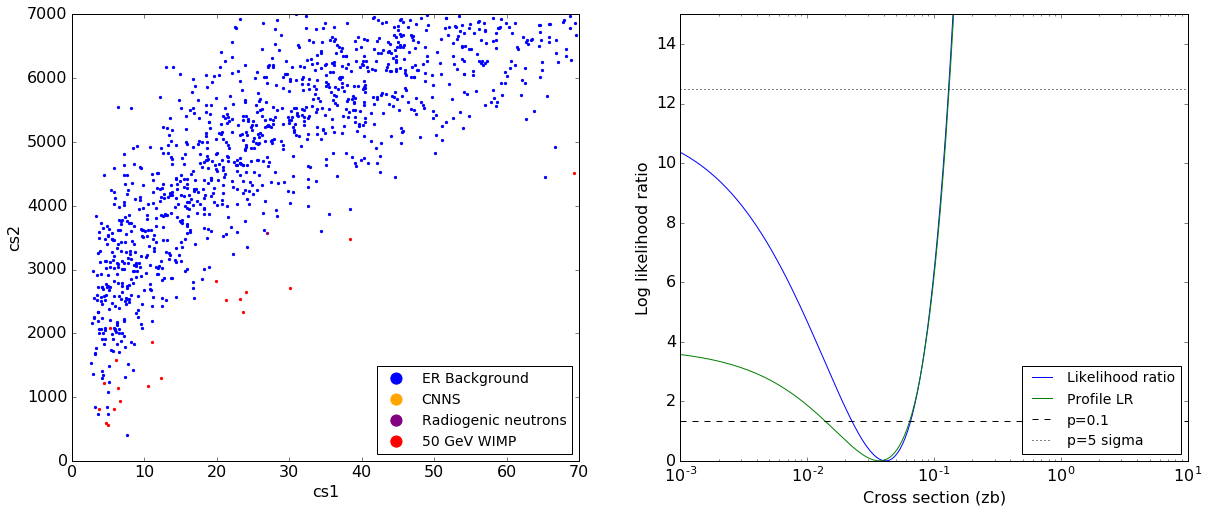

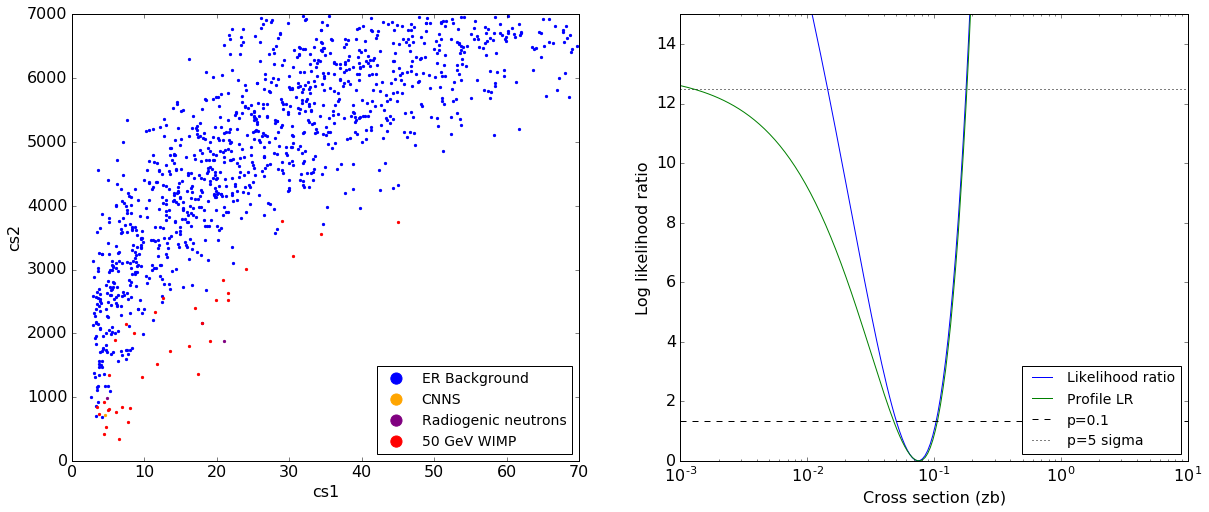

In [3]:
rate_multipliers = (0, 2e-2, 5e-2, 1e-1)
for i, mult in enumerate(rate_multipliers):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    plt.sca(ax1)
    
    d = lf.base_model.simulate(rate_multipliers=dict(wimp_50gev=mult))
    
    lf.base_model.show(d)
    plt.legend(loc='lower right', scatterpoints=1, markerscale=5, fontsize=14)
    
    plt.sca(ax2)
    lf.set_data(d)
    plf.set_data(d)
    space = ('wimp_50gev_rate_multiplier', np.logspace(-3, 1, 200))
    bi.plot_likelihood_ratio(lf, space,plot_kwargs=dict(label='Likelihood ratio'))
    bi.plot_likelihood_ratio(plf, space, plot_kwargs=dict(label='Profile LR'))
    
    # p=0.1 line from Wilks' theorem
    plt.axhline(stats.chi2(1).ppf(0.9)/2,
                label='p=0.1', color='k', linestyle='--')
    plt.axhline(stats.chi2(1).ppf(stats.norm.cdf(5) - stats.norm.cdf(-5))/2,
                label='p=5 sigma', color='k', linestyle=':')
    plt.legend(frameon=True, loc='lower right', fontsize=14)
    plt.xlabel("Cross section (zb)")
    plt.xscale('log')
    plt.show()

# Sensitivity check

The sentivity of the experiment is the median limit on background-only data. Let's compute it for both the likelihood and profile likelihood: (for the latter it is much slower, since it has to fit the nuisance parameter while searching out the limit). 

In [4]:
n_trials = 1000

limits_lf = np.zeros(n_trials)
limits_plf = np.zeros(n_trials)

background_datasets = [lf.base_model.simulate(rate_multipliers=dict(wimp_50gev=0)) for _ in range(n_trials)]

for i, d in enumerate(tqdm(background_datasets)):
    lf.set_data(d)
    plf.set_data(d)
    try:
        limits_lf[i] = bi.one_parameter_interval(lf, 'wimp_50gev_rate_multiplier', bound=1, kind='upper')
        limits_plf[i] = bi.one_parameter_interval(plf, 'wimp_50gev_rate_multiplier', bound=1, kind='upper')
    except bi.OptimizationFailed:
        print("Optimization failed for background dataset %d" % i)

Here is the median limit, both in the WIMP rate multiplier and WIMP rate cross section:

In [7]:
print(np.median(limits_lf), np.median(limits_lf) * 1e-45)

0.00718174252552 7.18174252552e-48


The Bologna model (without CLS) [gave](https://xecluster.lngs.infn.it/dokuwiki/doku.php?id=xenon:xenon1t:sim:notes:digangi:sensitivity-profile-likelihood-ratio#with_or_without_cls) 8.6e-48... a nice agreement, considering they are completely different codes using different data dimensions for analysis. 

The limits from the profile likelihood function (300% uncertainty on the neutron rate, remember) are of course worse, but they aren't very far off. This uncertainty would mostly impact a discovery claim, as you can see from the figures above.

In [8]:
print(np.median(limits_plf), np.median(limits_plf) * 1e-45)

0.00956897959773 9.56897959773e-48


# Coverage check

The limit setting code (`one_param_interval`) in wimpy.inference assumes Wilk's theorem holds, i.e. that the critical value for the loglikelihood ratio is as shown in the figures above. We can check this is indeed approximately true, by simulating many datasets at different WIMP masses, then computing the test statistic used in upper limit setting (twice the loglikelihood ratio, or 0 if the best fit is more signal-like than the hypothesis) at the true value.

The code will take some time, even though it only tests the ordinary likelihood ratio limit. If you have patience you can try the profile likelihood too: it will give similar results.

In [15]:
n_trials = int(1e4)
ts = {}

for rm in np.logspace(-3, 1, 7):
    ts[rm] = np.zeros(n_trials)
    for i in tqdm(range(n_trials), desc='Simulating likelihood ratios for '
                                        '%sx WIMP rate multiplier' % rm):
        d = lf.base_model.simulate(rate_multipliers=dict(wimp_50gev=rm))
        lf.set_data(d)
        
        # Evaluate the test statistic: 
        # 2 * (loglikelihood of global best fit - ll of best fit conditional on true wimp rate)
        try:
            bf = bestfit_scipy(lf)   # Global best fit. Loglikelihood is in [1]
            if bf[0]['wimp_50gev_rate_multiplier'] > rm:
                ts[rm][i] = 0
            else:
                ts[rm][i] = 2 * (bf[1] - bi.bestfit_minuit(lf, wimp_50gev_rate_multiplier=rm)[1])
                
        except bi.OptimizationFailed:
            print("Optimization failed for trial %d, storing nan as t value")
            ts[rm][i] = float('nan')

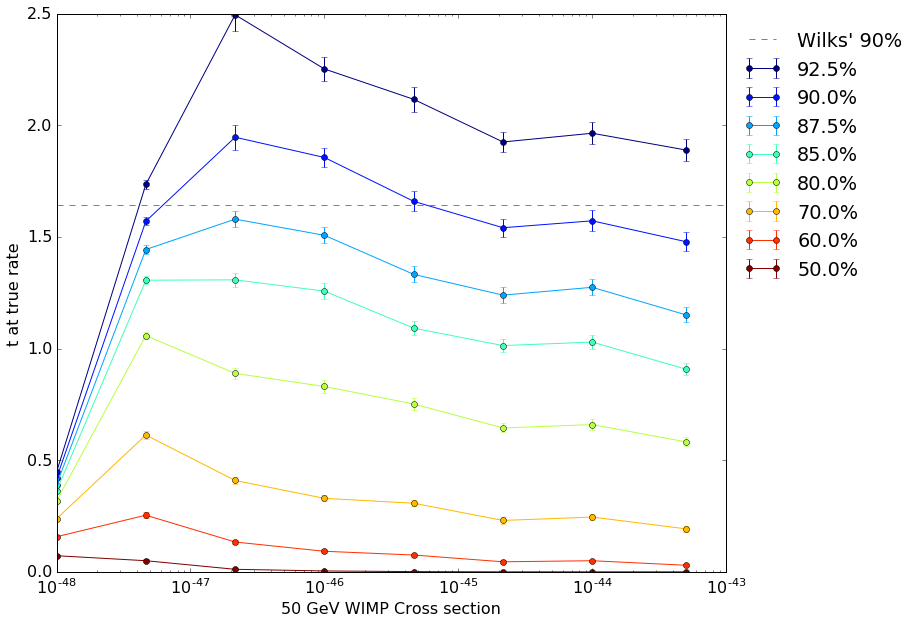

In [21]:
def bootstrap_percentile_error(q, pct, bootstrap_trials=200):
    return np.std([np.percentile(np.random.choice(q, len(q)), pct) for _ in range(bootstrap_trials)])

percentiles = [50, 60, 70, 80, 85, 87.5, 90, 92.5]
for i, pct in enumerate(tqdm(reversed(percentiles))):
    plt.errorbar(np.array(sorted(ts.keys())) * 1e-45, 
                 [np.percentile(q, pct) for _, q in sorted(ts.items())],
                 yerr=[bootstrap_percentile_error(q, pct) for _, q in sorted(ts.items())],
                 color=plt.cm.jet(i/(len(percentiles)-1)),
                 label='%0.1f%%' % pct,
                 marker='o', linestyle='-')
plt.xscale('log')
plt.axhline(stats.norm.ppf(0.9)**2, linestyle='--', color='gray', label="Wilks' 90%")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, frameon=False)
plt.xlabel("50 GeV WIMP Cross section")
plt.ylabel("t at true rate")
plt.ylim(0, 2.5)
plt.show()

As you can see, Wilks' theorem holds roughly, but there are some clear deviations. The error bars on the points are MC statistical uncertainties (estimated by bootstrapping). For the plot above I ran with an extra point at 5e-44 cm^2 for the plot above (which takes a very long time, as we have to simulate many wimps!).

  * At very low low cross sections, the asymptotic limits greatly _overcover_, i.e. are too conservative from a strict frequentist perspective. These low cross sections are essentially indistinguishable from having no WIMPs at all, which in those cases is usually the best fit. Overcoverage below the sensitivity is good though: you wouldn't want to exclude 1e-59 cm2 90% of t he time!
  * Next, we see an overshoot to some undercoverage. I think this is what we should expect, looking at https://www.pp.rhul.ac.uk/~cowan/stat/weizmann15/cowan_weizmann15_3.pdf, slide 26.
  * At very high rates we should expect Wilk's theorem to hold. However, it looks like we have some overcoverage still: I'm not sure why this is the case. 